In [1]:

import numpy as np
import scipy
import scipy.linalg as scila
import matplotlib as mpl
import matplotlib.pyplot as plt
import time as time
import networkx as nx
from sklearn.datasets import make_swiss_roll
from utils import *

import random
random.seed(12)
cmap = mpl.cm.viridis

from sklearn.neighbors import kneighbors_graph
import warnings
warnings.filterwarnings('ignore')

### Create a swiss roll graph

users can create their own graph 

In [2]:
n_samples = 250
X, _ = make_swiss_roll(n_samples)
# Make it thinner
X[:, 1] *= 0.5

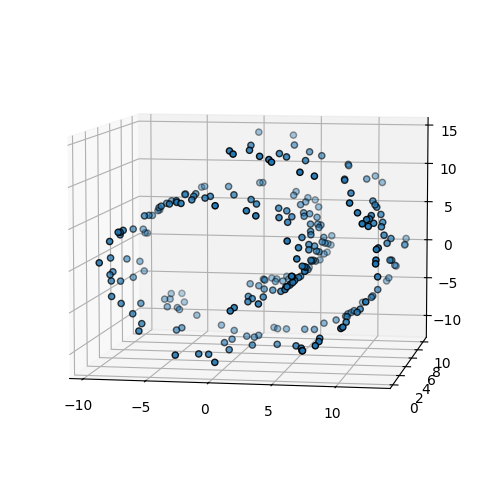

In [3]:
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False, mode='distance')
A = connectivity.toarray()
# compute the laplacian of the graph
L0 = scipy.sparse.csgraph.laplacian(A, normed=True, symmetrized=True)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
ax1.set_position([0, 0, 1, 1])
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], s=20, edgecolor="k")

### set the boundary distributions

In [4]:
n0 = L0.shape[0]
T_init = 0
T_end = 1
N = 100
dt = float(T_end - T_init)/N
Ts = np.arange(T_init, T_end+dt, dt)
assert Ts.size == N+1

In [5]:
def dW(delta_t: float, x) -> float:    
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t),size=x.shape)

In [6]:
mu_0 = np.zeros((n0,1))
mu_1 = np.zeros((n0,1))
cov_0 = compute_fractional_matrix_power(1*np.eye(n0)+L0, -1.5) 
cov_1 = 1*scila.expm(-20*L0) 

# eigenvalues and eigenvectors
evalues, evectors = np.linalg.eigh(L0)
cov_0_evalues = (evectors.T @ cov_0 @ evectors).diagonal()
cov_1_evalues = (evectors.T @ cov_1 @ evectors).diagonal()

## Gaussian TSB functions

Users can skip this part and directly go to the [function call](###GTSB-BM). We provide them here to show the details of the implementation.

1. related matrix functions for the solution, i.e., the operators in equations in Theorems 6 & 7

In [7]:
def transform_L(L):
    '''allows for other forms of the Laplacian'''
    return 0.* np.eye(n0) + 1*L

def H_t(c, L):
    '''define the drift'''
    L = transform_L(L)
    return -c * L

def Psi(c, t1, t2, L):
    assert t2 >= t1
    L = transform_L(L)
    return scila.expm(-c * (t2 - t1) * L)

def K(sigma, c, t1, t2, L):
    '''the cross covariance for TSB-BM'''
    L = transform_L(L)
    return sigma**2/2/c * ( 
                scila.expm(-c * abs(t2 - t1) * L) - scila.expm(-c * (t2 + t1) * L)
    ) @ np.linalg.pinv(L) 

In [8]:
def sigma_scale(sigma_min, sigma_max, t):
    return sigma_min * (sigma_max/sigma_min)**t

def g_constant(sigma_min, sigma_max):
    return np.sqrt(2*np.log(sigma_max/sigma_min))

def g_t(sigma_min, sigma_max, t):
    return sigma_scale(sigma_min, sigma_max, t) * g_constant(sigma_min, sigma_max)

def K_ve(sigma_min, sigma_max, c, t1, t2, L):
    '''the cross covariance for TSB-VE'''
    L = transform_L(L)
    A = np.log(sigma_max/sigma_min)*np.eye(L.shape[0]) + c * L 

    return sigma_min**2 * np.log(sigma_max/sigma_min) * scila.expm(-c * (t1+t2) *L) @ (scila.expm(2*min(t1,t2) * A) - np.eye(L.shape[0])) @ np.linalg.pinv(A)

In [9]:
def R_t(Kt1, K11):
    return Kt1 @ np.linalg.pinv(K11)

def R_t_bar(Psi_t, R_t_, Psi_1):
    return Psi_t - R_t_ @ Psi_1

def Upsilon_t(H_t_, Kt1, Psi_t, Psi_1, sigma):
    return H_t_ @ Kt1 + sigma**2 * np.linalg.pinv(Psi_t) @ Psi_1

def R_t_dot(Upsilon_t_, K11):
    return Upsilon_t_ @ np.linalg.pinv(K11)

def R_t_bar_dot(Psi_t, H_t_, Upsilon_t_, K11, Psi_1):
    return Psi_t @ H_t_ - Upsilon_t_ @ np.linalg.pinv(K11) @ Psi_1.T

def P_t(R_t_, Sigma_1_, R_t_bar_, C_sigma_, R_t_dot_):
    return (R_t_ @ Sigma_1_ + R_t_bar_ @ C_sigma_ ) @ R_t_dot_.T

def Q_t(R_t_bar_dot_, C_sigma_, R_t_, Sigma_0_, R_t_bar_):
    return - R_t_bar_dot_ @ (C_sigma_ @ R_t_.T + Sigma_0_ @ R_t_bar_.T)

In [10]:
def Sigma_0_tilde(K11, Psi_1, Sigma_0_,):
    return compute_fractional_matrix_power(K11,-0.5) @ Psi_1 @ Sigma_0_ @ Psi_1.T @ compute_fractional_matrix_power(K11,-0.5)

def Sigma_1_tilde(K11, Sigma_1_): 
    return compute_fractional_matrix_power(K11,-0.5) @ Sigma_1_ @ compute_fractional_matrix_power(K11,-0.5) 

def D_tilde(Sigma_0_tilde_, Sigma_1_tilde_, sigma=1): 
    return compute_fractional_matrix_power( 4 * compute_fractional_matrix_power(Sigma_0_tilde_, 0.5) @ Sigma_1_tilde_ @ compute_fractional_matrix_power(Sigma_0_tilde_, 0.5)  + sigma**4 * np.eye(n0), 0.5 )

def C_tilde(Sigma_0_tilde_, D_tilde_, sigma=1): 
    return 0.5 * (compute_fractional_matrix_power(Sigma_0_tilde_, 0.5) @ D_tilde_ @ compute_fractional_matrix_power(Sigma_0_tilde_, -0.5) - sigma**2 * np.eye(n0) )

def C_sigma(Psi_1, K11, C_tilde_): 
    return np.linalg.pinv(Psi_1) @ compute_fractional_matrix_power(K11, 0.5) @ C_tilde_ @ compute_fractional_matrix_power(K11, 0.5)

def S_t(P_t_, Q_t_, H_t_, Ktt, K11, Kt1, Upsilon_t_):
    return P_t_ - Q_t_.T + H_t_ @ Ktt - Kt1 @ np.linalg.pinv(K11) @ Upsilon_t_.T

def Sigma_t(Sigma_0_, Sigma_1_, R_t_, R_t_bar_, C_sigma_, Ktt, Kt1, K11, K1t):
    return R_t_bar_ @ Sigma_0_ @ R_t_bar_.T \
        + R_t_ @ Sigma_1_ @ R_t_.T \
            + R_t_bar_ @ C_sigma_ @ R_t_.T \
                + R_t_ @ C_sigma_ @ R_t_bar_.T \
                    + Ktt - Kt1 @ np.linalg.pinv(K11) @ K1t 

def Sigma_t_0(Sigma_0_, Sigma_1_, R_t_, R_t_bar_, C_sigma_, Ktt, Kt1, K11, K1t):
    return  R_t_ @ Sigma_1_ @ R_t_.T - \
        R_t_ @ C_sigma_.T @ np.linalg.pinv(Sigma_0_) @ C_sigma_ @ R_t_.T + \
        + Ktt - Kt1 @ np.linalg.pinv(K11) @ K1t 

def mu_t_0(Sigma_0_, Sigma_1_, R_t_, R_t_bar_, C_sigma_, Ktt, Kt1, K11, K1t, x0):
    return  R_t_bar_ @ x0 + R_t_@ (C_sigma_.T @ np.linalg.pinv(Sigma_0_) @ x0)

2. routine to compute the solution

In [11]:
def gtsb_closed_form(scheme='tsb-bm', c=1, g=None, sigma_min=None, sigma_max=None):
    if scheme == 'tsb-bm':
        sigma_min = None
        sigma_max = None
        assert g is not None
    elif scheme == 'tsb-ve':
        g = None
        assert sigma_min is not None
        assert sigma_max is not None
    else:
        raise ValueError('scheme not recognized')
    
    np.random.seed(1)
    v = np.random.multivariate_normal(mean=np.zeros(n0), cov=np.eye(n0))
    f_init = evectors @ (np.sqrt(cov_0_evalues) * v)
    xs = np.zeros((n0, N+2))
    xs[:,0] = f_init 
    cov_t = []
    x_i_list = []
    Psi_1 = Psi(c, 0, T_end, L0)
    
    if scheme == 'tsb-bm':
        K_11 = K(g, c, T_end, T_end, L0)
    elif scheme == 'tsb-ve':
        K_11 = K_ve(sigma_min, sigma_max, c, T_end, T_end, L0)
        
    Sigma_0_tilde_ = Sigma_0_tilde(K_11, Psi_1, cov_0)
    Sigma_1_tilde_ = Sigma_1_tilde(K_11, cov_1)
    D_tilde_ = D_tilde(Sigma_0_tilde_, Sigma_1_tilde_)
    C_tilde_ = C_tilde(Sigma_0_tilde_, D_tilde_)
    C_sigma_ = C_sigma(Psi_1, K_11, C_tilde_)

    for i in range(1, Ts.size+1):
        t = T_init + (i-1) * dt
        x = xs[:, i-1] 
        
        if scheme == 'tsb-ve':
            g = g_t(sigma_min, sigma_max, t)
            
        H_t_ = H_t(c, L0)
        Psi_t = Psi(c, 0, t, L0)
        
        if scheme == 'tsb-bm':
            K_tt = K(g, c, t, t, L0)
            K_t1 = K(g, c, t, T_end, L0)
            K_1t = K(g, c, T_end, t, L0)
        elif scheme == 'tsb-ve':
            K_tt = K_ve(sigma_min, sigma_max, c, t, t, L0)
            K_t1 = K_ve(sigma_min, sigma_max, c, t, T_end, L0)
            K_1t = K_ve(sigma_min, sigma_max, c, T_end, t, L0)
        
        R_t_ = R_t(K_tt, K_11)
        R_t_bar_ = R_t_bar(Psi_t, R_t_, Psi_1)
        Upsilon_t_ = Upsilon_t(H_t_, K_t1, Psi_t, Psi_1, g)
        R_t_dot_ = R_t_dot(Upsilon_t_, K_11)
        R_t_bar_dot_ = R_t_bar_dot(Psi_t, H_t_, Upsilon_t_, K_11, Psi_1)
        P_t_ = P_t(R_t_, cov_1, R_t_bar_, C_sigma_, R_t_dot_)
        Q_t_ = Q_t(R_t_bar_dot_, C_sigma_, R_t_, cov_0, R_t_bar_)
        S_t_ = S_t(P_t_, Q_t_, H_t_, K_tt, K_11, K_t1, Upsilon_t_)
        
        '''Thm. 6'''
        Sigma_t_ = Sigma_t(cov_0, cov_1, R_t_, R_t_bar_, C_sigma_, K_tt, K_t1, K_11, K_1t).real
        '''Cov_t update''' 
        cov_t.append(Sigma_t_)
        
        # print(np.linalg.norm(Sigma_t_-cov_1),)
        '''sample from the conditional distribution'''
        Sigma_t_0_ = Sigma_t_0(cov_0, cov_1, R_t_, R_t_bar_, C_sigma_, K_tt, K_t1, K_11, K_1t)
        mu_t_0_ = mu_t_0(cov_0, cov_1, R_t_, R_t_bar_, C_sigma_, K_tt, K_t1, K_11, K_1t, f_init)
        f_normal =  (S_t_ @ np.linalg.pinv(Sigma_t_)) @ xs[:, i-1]
        '''Thm. 7'''
        xs[:,i] = xs[:, i-1]  + dt * f_normal + 1 * g * dW(dt, f_init)
        
        '''x_i update'''
        Sigma_t_0_evalues = (evectors.T @ Sigma_t_0_ @ evectors).diagonal()
        x_i = mu_t_0_ + evectors @ (np.sqrt(Sigma_t_0_evalues) * v)
        x_i_list.append(x_i)
        del x 
        x_i = np.array(x_i_list).T
        
    return cov_t, x_i

### GTSB-BM

In [12]:
c = 1
g = 0.01

cov_t_tsb_bm, x_i_tsb_bm = gtsb_closed_form(scheme='tsb-bm', c=c, g=g)

### GTSB-VE 1

In [13]:
sigma_min = 0.01
sigma_max = 1
c = 0.05

cov_t_tsb_ve, x_i_tsb_ve = gtsb_closed_form(scheme='tsb-ve', c=c, sigma_min=sigma_min, sigma_max=sigma_max)

### GTSB-VE 2

In [14]:
sigma_min = 0.01
sigma_max = 1
c = 10

cov_t_tsb_ve2, x_i_tsb_ve2 = gtsb_closed_form(scheme='tsb-ve', c=c, sigma_min=sigma_min, sigma_max=sigma_max)

### Compare the results of different bridges  

In [ ]:
dist_dcor_1 = []
dist_dcor_2 = []
dist_dcor_3 = []

for i, cov in enumerate(cov_t_tsb_bm):
    dist_dcor_1.append(bw_distance(cov_1, cov_t_tsb_bm[i]))
    dist_dcor_2.append(bw_distance(cov_1, cov_t_tsb_ve[i]))
    dist_dcor_3.append(bw_distance(cov_1, cov_t_tsb_ve2[i]))


Text(0, 0.5, '$W_2^2$')

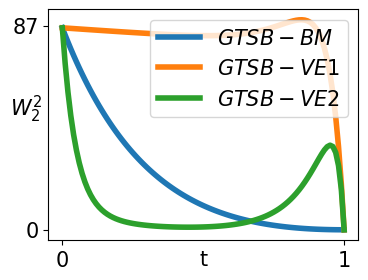

In [ ]:
# plot the distance covariance
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(Ts, dist_dcor_1, label='$GTSB-BM$', linewidth=4)
ax.plot(Ts, dist_dcor_2, label='$GTSB-VE1$', linewidth=4)
ax.plot(Ts, dist_dcor_3, label='$GTSB-VE2$', linewidth=4)
ax.legend(fontsize=15, loc='upper right')
# add lables of the curves to the curves 
# set font size
ax.tick_params(axis='both', which='major', labelsize=15)
# set three two x ticks
ax.set_xticks([0, 1])
# add the x label
ax.set_xlabel('t', fontsize=15, labelpad=-15)
# use the maximal value among all distances as the yticks
ax.set_yticks([0, np.ceil(dist_dcor_1[0].real)])
ax.set_ylabel('$W_2^2$', fontsize=15, labelpad=-10, rotation=0)